<a href="https://colab.research.google.com/github/walterfolk/Coder_DSIII_NLP/blob/main/CODER_DS_III_Folk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CODERHOUSE DS III - TP FINAL**
  
## **Resumen**
  Hoy en día, los comentarios de los clientes y revisores afectan las futuras compras de esos mismos revisores y de nuevos clientes. Poder prevenir los comentarios negativos es uno de los procesos principales para mantener a los clientes, pero un problema para mejorar el negocio con la retroalimentación es comprender el verdadero significado de esas reseñas, dado que el factor humano es tan sensible, una empresa necesita invertir mucho tiempo en analizarlo. Es por eso que se decide crear este **Predictor de Satisfacción del Revisor** el cual clasifica las reseñas en positivas y negativas, ahorrando tiempo en la evaluación de la satisfacción. Con acceso directo a palabras clave de cada reseña, la empresa podrá identificar rápidamente las áreas de mejora. Este predictor ofrece una alta precisión por encima del 90% según las pruebas realizadas con un conjunto de validación.

##**Objetivo**
  Este conjunto de datos contiene más de 1000 reseñas de clientes que compraron instrumentos musicales en línea por Amazon.

  Se requiere realizar un Análisis de Sentimiento de estos datos para ayudar a la organización a comprender mejor la opinión de sus clientes y, así, concentrarse en los problemas que enfrentan. El objetivo es construir un modelo con la mayor precisión posible para clasificar las reseñas como positivas, negativas o neutras.

  Considero que, para obtener una mejor perspectiva del negocio, las reseñas neutras deberían considerarse más cercanas a las negativas que a una categoría neutral independiente. Esto se debe a que las reseñas neutras suelen indicar que no se satisficieron completamente las necesidades del cliente, y además, no proporcionan información útil para realizar mejoras. Continuar analizando las reseñas neutras podría generar costos innecesarios.

# **Setup**
A continuación se carga el dataset y algunas librerias necesarias para poder leer el dataset que se encuentra comprimido en un archivo .zip y subido a un repositorio de GitHub el cual contine los datos de las revisiones de los clientes.

In [4]:
import pandas as pd
import re
import collections
import matplotlib.pyplot as plt
import requests
import zipfile
import io

url = "https://github.com/walterfolk/Coder_DSIII_NLP/blob/main/Musical_instruments_reviews.csv.zip?raw=true"
response = requests.get(url)
response.raise_for_status()

with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    with z.open('Musical_instruments_reviews.csv') as f:
        df = pd.read_csv(f)


print(df.head())

       reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName   helpful  \
0  cassandra tu "Yeah, well, that's just like, u...    [0, 0]   
1                                              Jake  [13, 14]   
2                     Rick Bennette "Rick Bennette"    [1, 1]   
3                         RustyBill "Sunday Rocker"    [0, 0]   
4                                     SEAN MASLANKA    [0, 0]   

                                          reviewText  overall  \
0  Not much to write about here, but it does exac...      5.0   
1  The product does exactly as it should and is q...      5.0   
2  The primary job of this device is to block the...      5.0   
3  Nice windscreen protects my MXL mic and preven...      5.0   
4  This pop filter is great. It looks and perform...      5.0   

                   

In [5]:
df.shape

(10261, 9)

### Corroboramos los datos nulos presentes en el dataset

In [6]:
df.isna().sum()

,0
reviewerID,0
asin,0
reviewerName,27
helpful,0
reviewText,7
overall,0
summary,0
unixReviewTime,0
reviewTime,0


### Como podemos obser existen algunos datos nulos los cuales se proceden a rellenar con "" que es el valor con el que se reemplazarán los valores NaN. En otras palabras, cualquier valor faltante en la columna reviewText se convertirá en una cadena de texto vacía.

In [7]:
df.reviewText.fillna('', inplace = True)

<ipython-input-7-6b2a1c2ff75e>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.reviewText.fillna('', inplace = True)


### Se proceden a eliminas a aquellas columnas que no son importantes para el objetivo planteado

In [8]:
df = df.drop(['reviewerID', 'asin', 'reviewerName', 'helpful', 'unixReviewTime', 'reviewTime'], axis=1)

In [9]:
df.head()

,reviewText,overall,summary
0,"Not much to write about here, but it does exac...",5.0,good
1,The product does exactly as it should and is q...,5.0,Jake
2,The primary job of this device is to block the...,5.0,It Does The Job Well
3,Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY
4,This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.


### Creamos una nueva columna concatenando los valores de las columnas 'reviewText' y 'summary' a la cual llamaremos 'text'. Luego procedemos a eliminar las columnas 'reviewText' y 'summary'

In [10]:
df['text'] = df['reviewText'] + ' ' + df['summary']
df = df.drop(['reviewText', 'summary'], axis=1)

In [108]:
df.head()

,overall,text
0,5.0,"Not much to write about here, but it does exac..."
1,5.0,The product does exactly as it should and is q...
2,5.0,The primary job of this device is to block the...
3,5.0,Nice windscreen protects my MXL mic and preven...
4,5.0,This pop filter is great. It looks and perform...


### Procedemos a realizar un recuento de los valores de la columna 'overall' para saber cuantas calificaciones hay en cada uno de los valores (1 al 5)

In [11]:
df.overall.value_counts()

,count
overall,
5.0,6938
4.0,2084
3.0,772
2.0,250
1.0,217


### Tal como se explicó en el objetivo se toman las reseñas consideradas neutrales (aquellas con un valor igual a 3) como negativas. Por lo cual a continuación se procede a se para las reseñas entre "Positivas" con un valor igual a 1 y "Negativas" con un valor de 0.

In [12]:
df['sentiment'] = df['overall'].apply(lambda rating: '1' if rating > 3 else '0')

### Una vez realizada la clasificación de las review se elimina la columna 'overall'

In [13]:
df['sentiment'].value_counts()

,count
sentiment,
1,9022
0,1239


In [14]:
df.drop('overall', axis=1, inplace=True)

In [15]:
df.head()

,text,sentiment
0,"Not much to write about here, but it does exac...",1
1,The product does exactly as it should and is q...,1
2,The primary job of this device is to block the...,1
3,Nice windscreen protects my MXL mic and preven...,1
4,This pop filter is great. It looks and perform...,1


In [16]:
df.isnull().sum()

,0
text,0
sentiment,0


### A continuacion realizamos un gráfico de barras para observar las reseñas "Positivas" y "Negativas"

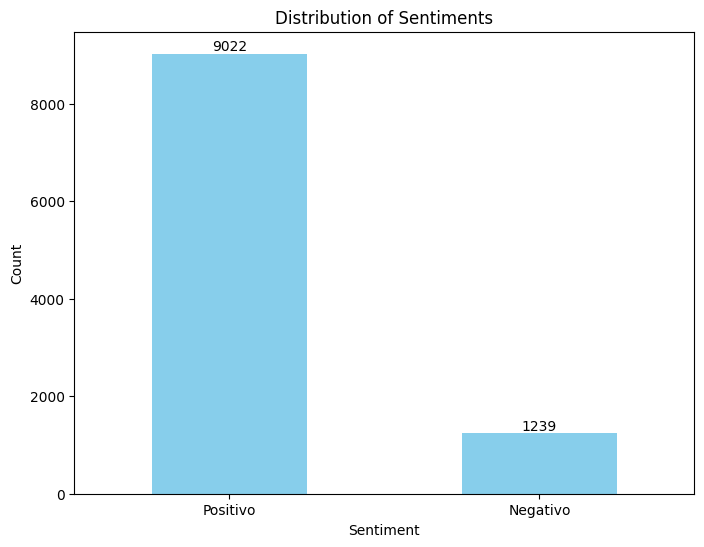

In [17]:
plt.figure(figsize=(8, 6))
sentiment_counts = df['sentiment'].value_counts()
sentiment_counts.plot(kind='bar', color='skyblue')

# Label the bars with sentiment labels
for i, count in enumerate(sentiment_counts):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')

# Label the graph with sentiment labels
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(range(len(sentiment_counts)), ['Positivo', 'Negativo'], rotation=0)
plt.show()

##**Utilización de la librecia SpaCy**
### Spacy proporciona las herramientas necesarias para realizar un preprocesamiento de texto avanzado, incluyendo tokenización, lematización y filtrado de palabras, lo cual es esencial para muchas tareas de NLP como el análisis de sentimiento, la clasificación de texto o la extracción de información. En estecaso específico, ésta librería se usa para limpiar el texto, dejando solo las palabras relevantes en su forma base y en minúsculas, preparándolo para un análisis posterior.

In [18]:
import spacy
import string

nlp = spacy.load("en_core_web_sm")


def preprocess_text(text):

    doc = nlp(text)
    cleaned_tokens = []
    for token in doc:
        if token.is_alpha and not token.is_punct and not token.is_stop:
            cleaned_token = token.lemma_.lower()
            cleaned_tokens.append(cleaned_token)

    cleaned_text = ' '.join(cleaned_tokens)
    return cleaned_text

### Aplicando la función de procesamiento de texto a la columna 'text' para su posterior utilización en los modelos de NLP creando la columna 'cleaned_review'.

In [19]:
df['cleaned_review'] = df['text'].apply(preprocess_text)

print(df[['text', 'cleaned_review']].head())

                                                text  \
0  Not much to write about here, but it does exac...   
1  The product does exactly as it should and is q...   
2  The primary job of this device is to block the...   
3  Nice windscreen protects my MXL mic and preven...   
4  This pop filter is great. It looks and perform...   

                                      cleaned_review  
0  write exactly suppose filter pop sound recordi...  
1  product exactly affordable realize double scre...  
2  primary job device block breath produce poppin...  
3  nice windscreen protect mxl mic prevent pop th...  
4  pop filter great look perform like studio filt...  


In [20]:
df.head()

,text,sentiment,cleaned_review
0,"Not much to write about here, but it does exac...",1,write exactly suppose filter pop sound recordi...
1,The product does exactly as it should and is q...,1,product exactly affordable realize double scre...
2,The primary job of this device is to block the...,1,primary job device block breath produce poppin...
3,Nice windscreen protects my MXL mic and preven...,1,nice windscreen protect mxl mic prevent pop th...
4,This pop filter is great. It looks and perform...,1,pop filter great look perform like studio filt...


### Se elimina la columna 'text' quedando solamnete la columna 'sentiment' y 'cleaned_review'

In [21]:
df.drop('text', axis = 1)

,sentiment,cleaned_review
0,1,write exactly suppose filter pop sound recordi...
1,1,product exactly affordable realize double scre...
2,1,primary job device block breath produce poppin...
3,1,nice windscreen protect mxl mic prevent pop th...
4,1,pop filter great look perform like studio filt...
...,...,...
10256,1,great expect thank star
10257,1,think try nanoweb string bit high price cost t...
10258,1,try coated string past include elixirs fond tr...
10259,1,elixir developed taylor guitars string design ...


# **Implementación de los modelos de calsificación**
### A continuación se importan los modelos de Native Bayes, Regresión Logística y Random Fores como tambien los reportes de calsificación para obtener los valores de las métricas de cada uno de los modelos.

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

X = df['cleaned_review']

y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
nb_pred = nb_model.predict(X_test_tfidf)
nb_report = classification_report(y_test, nb_pred)

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)
lr_pred = lr_model.predict(X_test_tfidf)
lr_report = classification_report(y_test, lr_pred)

rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train_tfidf, y_train)
rf_pred = rf_model.predict(X_test_tfidf)
rf_report = classification_report(y_test, rf_pred)

print("Naive Bayes Classification Report:")
print(nb_report)
print("Logistic Regression Classification Report:")
print(lr_report)
print("Random Forest Classification Report:")
print(rf_report)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       244
           1       0.88      1.00      0.94      1809

    accuracy                           0.88      2053
   macro avg       0.44      0.50      0.47      2053
weighted avg       0.78      0.88      0.83      2053

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.09      0.15       244
           1       0.89      1.00      0.94      1809

    accuracy                           0.89      2053
   macro avg       0.81      0.54      0.55      2053
weighted avg       0.87      0.89      0.85      2053

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.08      0.14       244
           1       0.89      0.99      0.94      1809

    accuracy                           0.89      2053
   macro avg 

### Se muestran los valores de Precisión, Recall y F1 de todos los modelos utilizados

In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score

nb_precision = precision_score(y_test, nb_pred, average='weighted')
nb_recall = recall_score(y_test, nb_pred, average='weighted')
nb_f1 = f1_score(y_test, nb_pred, average='weighted')

lr_precision = precision_score(y_test, lr_pred, average='weighted')
lr_recall = recall_score(y_test, lr_pred, average='weighted')
lr_f1 = f1_score(y_test, lr_pred, average='weighted')

rf_precision = precision_score(y_test, rf_pred, average='weighted')
rf_recall = recall_score(y_test, rf_pred, average='weighted')
rf_f1 = f1_score(y_test, rf_pred, average='weighted')


print("Naive Bayes:")
print("Precision:", nb_precision)
print("Recall:", nb_recall)
print("F1-score:", nb_f1)
print()

print("Logistic Regression:")
print("Precision:", lr_precision)
print("Recall:", lr_recall)
print("F1-score:", lr_f1)
print()

print("Random Forest:")
print("Precision:", rf_precision)
print("Recall:", rf_recall)
print("F1-score:", rf_f1)

Naive Bayes:
Precision: 0.7764245070179929
Recall: 0.8811495372625426
F1-score: 0.8254787741625788

Logistic Regression:
Precision: 0.8701304901505763
Recall: 0.887481734047735
F1-score: 0.846330768813365

Random Forest:
Precision: 0.8577677927788421
Recall: 0.885046273745738
F1-score: 0.844078865820689


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Con el fin de obtener una mejora en los resultados de los modelos se procede a realizar un GridSearchCV para lograr obtener los mejores hiperparámetros para cada uno y comparar sus rendimientos.

Best parameters for Naive Bayes: {'alpha': 0.1}
Best cross-validation score for Naive Bayes: 0.8343135601475737
              precision    recall  f1-score   support

           0       1.00      0.05      0.09       244
           1       0.89      1.00      0.94      1809

    accuracy                           0.89      2053
   macro avg       0.94      0.52      0.52      2053
weighted avg       0.90      0.89      0.84      2053

Best parameters for Logistic Regression: {'C': 10}
Best cross-validation score for Logistic Regression: 0.8740597113362014
              precision    recall  f1-score   support

           0       0.58      0.29      0.38       244
           1       0.91      0.97      0.94      1809

    accuracy                           0.89      2053
   macro avg       0.75      0.63      0.66      2053
weighted avg       0.87      0.89      0.87      2053

Best parameters for Random Forest: {'max_depth': None, 'n_estimators': 50}
Best cross-validation score for Rand

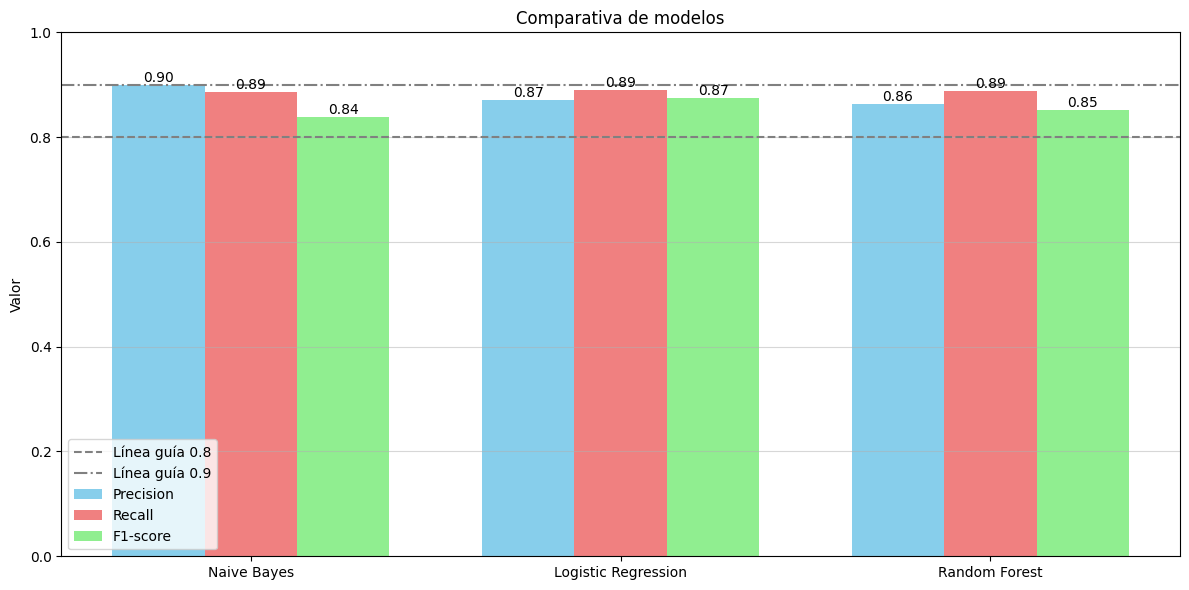

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

X = df['cleaned_review']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

models = {
    'Naive Bayes': (MultinomialNB(), {'alpha': [0.1, 0.5, 1.0]}),
    'Logistic Regression': (LogisticRegression(max_iter=1000), {'C': [0.1, 1, 10]}),
    'Random Forest': (RandomForestClassifier(), {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]})
}

best_model = None
best_score = 0


precision_scores = {}
recall_scores = {}
f1_scores = {}

for model_name, (model, param_grid) in models.items():
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_weighted')
    grid_search.fit(X_train_tfidf, y_train)

    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best cross-validation score for {model_name}: {grid_search.best_score_}")

    y_pred = grid_search.predict(X_test_tfidf)
    print(classification_report(y_test, y_pred))

    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    precision_scores[model_name] = precision
    recall_scores[model_name] = recall
    f1_scores[model_name] = f1

    if f1 > best_score:
        best_score = f1
        best_model = (model_name, grid_search.best_estimator_)

print(f"\nBest Model: {best_model[0]} with F1-score: {best_score}")


models_names = list(models.keys())
precision_values = [precision_scores[model] for model in models_names]
recall_values = [recall_scores[model] for model in models_names]
f1_values = [f1_scores[model] for model in models_names]

x = np.arange(len(models_names))
width = 0.25

plt.figure(figsize=(12, 6))

plt.axhline(y=0.8, color='gray', linestyle='--', label='Línea guía 0.8')
plt.axhline(y=0.9, color='gray', linestyle='-.', label='Línea guía 0.9')

precision_bars = plt.bar(x - width, precision_values, width, label='Precision', color='skyblue')
recall_bars = plt.bar(x, recall_values, width, label='Recall', color='lightcoral')
f1_bars = plt.bar(x + width, f1_values, width, label='F1-score', color='lightgreen')

for bar in precision_bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.2f}',
             ha='center', va='bottom', fontsize=10)
for bar in recall_bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.2f}',
             ha='center', va='bottom', fontsize=10)
for bar in f1_bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.2f}',
             ha='center', va='bottom', fontsize=10)

plt.xticks(x, models, rotation=0)
plt.ylabel('Valor')
plt.title('Comparativa de modelos')
plt.ylim(0, 1.0)
plt.grid(axis='y', alpha=0.5)

plt.legend()
plt.tight_layout()
plt.show()


### Luego de utilizar GridSearchCV se obtine una mejora en el modelo de Regresión Logística pasando de un rendimiento en F1 Score de **0.84** a **0.87**

# **Tensorflow**
### A continuación se utilizara la biblioteca Tensrflow de ML para entrenar redes neuronales con el fin de probar si es posible poder obtener una mejora en el rendimiento a la hora del análisis de sentimiento.

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D, Bidirectional
from tensorflow.keras.layers import Conv1D, Flatten, GRU, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

In [26]:
def plot_history(history):
    plt.figure(figsize=(10, 4))


    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

### El siguiente código prepara datos de texto para un modelo de clasificación de sentimientos mediante:

*   La tokenización del texto en secuencias numéricas.
*   El relleno de las secuencias a una longitud fija.
*   La codificación one-hot de las etiquetas de sentimiento.
*   La división de los datos en conjuntos de entrenamiento y prueba.
*   El cálculo de los pesos de clase para manejar el desequilibrio de clases.
*   La determinación del tamaño del vocabulario.

### Estos datos preprocesados se pueden usar luego para entrenar un modelo de red neuronal (por ejemplo, una LSTM o una CNN) para el análisis de sentimientos.

In [28]:
import numpy as np
NUM_WORDS = 30_000
MAX_SEQUENCE_LENGTH = 32
OOV_TOKEN = '<OOV>'
PADDING = 'post'

tokenizer = Tokenizer(num_words=NUM_WORDS, split=' ', oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(df["cleaned_review"])
X = tokenizer.texts_to_sequences(df["cleaned_review"])
X = pad_sequences(X, maxlen = MAX_SEQUENCE_LENGTH, padding=PADDING, truncating=PADDING)

Y = pd.get_dummies(df['sentiment']).values

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, stratify=df["sentiment"], test_size = 0.1, random_state = 43, shuffle=True)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

class_weights = compute_class_weight(class_weight = "balanced",
                                     classes = np.unique(Y.argmax(axis=1)), y = Y.argmax(axis=1))
class_weights = dict(zip(np.unique(Y.argmax(axis=1)), class_weights))
print("class_weights: ", class_weights)

vocab_size = len(tokenizer.word_index) + 1

(9234, 32) (9234, 2)
(1027, 32) (1027, 2)
class_weights:  {0: 4.1408393866020985, 1: 0.5686654843715362}


In [29]:
!pip install --upgrade tensorflow
!pip install --upgrade tensorflow-gpu
!pip install --upgrade tensorflow-estimator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.4/615.4 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 91.9 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-tpu 2.17.0 requires tensorboard<2.18,>=2.17, but you have tensorboard 2.18.0 which is incompatible.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.
tensorflow-text 2.17.0 requires tensorflow<2.18,>=2.17.0, but you have tensorflow 2.18.0 which is incompatib

ERROR: Operation cancelled by user
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 6.4 MB/s eta 0:00:00


### El código a continuación define una función para entrenar un modelo de clasificación de texto por lotes en TensorFlow. El código pre procesa los datos de texto, define la arquitectura del modelo, lo entrena y evalúa su rendimiento utilizando métricas de rendimiento estándar.

Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8377 - loss: 0.4866 - val_accuracy: 0.8825 - val_loss: 0.3673 - learning_rate: 0.0010
Epoch 2/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.8802 - loss: 0.3860 - val_accuracy: 0.8825 - val_loss: 0.3602 - learning_rate: 0.0010
Epoch 3/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8772 - loss: 0.3666 - val_accuracy: 0.8825 - val_loss: 0.3418 - learning_rate: 0.0010
Epoch 4/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8804 - loss: 0.3197 - val_accuracy: 0.8831 - val_loss: 0.3065 - learning_rate: 0.0010
Epoch 5/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8974 - loss: 0.2631 - val_accuracy: 0.8892 - val_loss: 0.3421 - learning_rate: 0.0010
Epoch 6/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9133 - loss: 0.2279 - val_accuracy: 0.8873 - val_loss: 0.3531 - learning_rate: 0.0010
Epoch 7/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9348 - loss: 0.1831 - val_

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Modelo Modelo_Batch_32:
Accuracy: 0.8792011690209449
F1 Score: 0.8226843494467629
ROC-AUC: 0.826206326512376
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       248
           1       0.88      1.00      0.94      1805

    accuracy                           0.88      2053
   macro avg       0.44      0.50      0.47      2053
weighted avg       0.77      0.88      0.82      2053



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


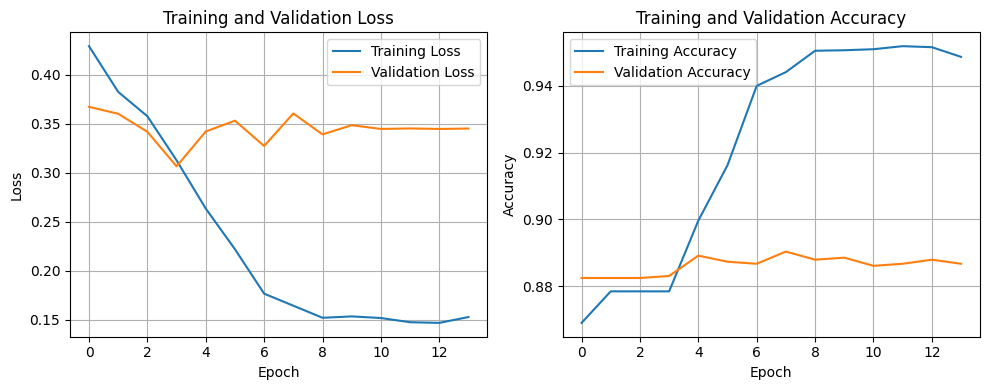

Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


103/103 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.8479 - loss: 0.4815 - val_accuracy: 0.8825 - val_loss: 0.3669 - learning_rate: 0.0010
Epoch 2/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8863 - loss: 0.3739 - val_accuracy: 0.8825 - val_loss: 0.3565 - learning_rate: 0.0010
Epoch 3/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8776 - loss: 0.3749 - val_accuracy: 0.8825 - val_loss: 0.3470 - learning_rate: 0.0010
Epoch 4/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8797 - loss: 0.3497 - val_accuracy: 0.8825 - val_loss: 0.3630 - learning_rate: 0.0010
Epoch 5/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8752 - loss: 0.3235 - val_accuracy: 0.8825 - val_loss: 0.3022 - learning_rate: 0.0010
Epoch 6/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8830 - loss: 0.2677 - val_accuracy: 0.8892 - val_loss: 0.3195 - learning_rate: 0.0010
Epoch 7/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9082 - loss: 0.2310 - val_

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Modelo Modelo_Batch_64:
Accuracy: 0.8792011690209449
F1 Score: 0.8226843494467629
ROC-AUC: 0.8389665802877312
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       248
           1       0.88      1.00      0.94      1805

    accuracy                           0.88      2053
   macro avg       0.44      0.50      0.47      2053
weighted avg       0.77      0.88      0.82      2053



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


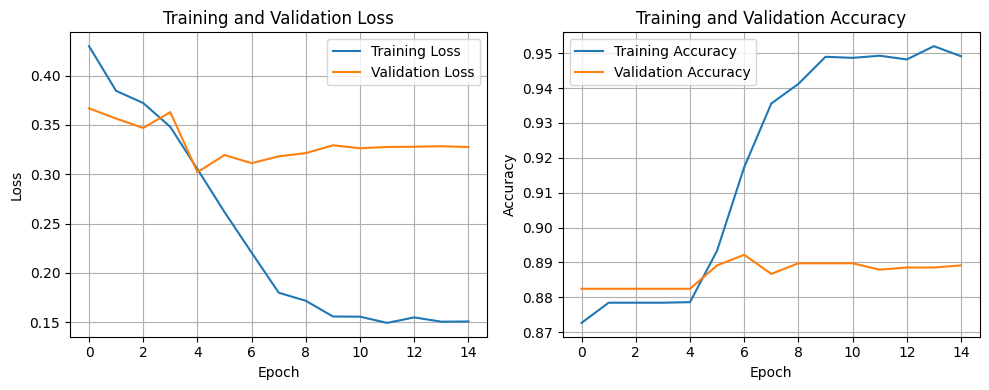

Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8340 - loss: 0.5094 - val_accuracy: 0.8825 - val_loss: 0.3754 - learning_rate: 0.0010
Epoch 2/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8831 - loss: 0.4066 - val_accuracy: 0.8825 - val_loss: 0.3624 - learning_rate: 0.0010
Epoch 3/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8683 - loss: 0.4136 - val_accuracy: 0.8825 - val_loss: 0.3528 - learning_rate: 0.0010
Epoch 4/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.8794 - loss: 0.3674 - val_accuracy: 0.8825 - val_loss: 0.3464 - learning_rate: 0.0010
Epoch 5/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.8790 - loss: 0.3616 - val_accuracy: 0.8825 - val_loss: 0.3373 - learning_rate: 0.0010
Epoch 6/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8808 - loss: 0.3336 - val_accuracy: 0.8825 - val_loss: 0.3279 - learning_rate: 0.0010
Epoch 7/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8836 - loss: 0.3039 - val_accuracy: 0.88

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Modelo Modelo_Batch_128:
Accuracy: 0.8840720896249391
F1 Score: 0.8411984591693197
ROC-AUC: 0.8393418818693593
              precision    recall  f1-score   support

           0       0.68      0.08      0.14       248
           1       0.89      1.00      0.94      1805

    accuracy                           0.88      2053
   macro avg       0.78      0.54      0.54      2053
weighted avg       0.86      0.88      0.84      2053



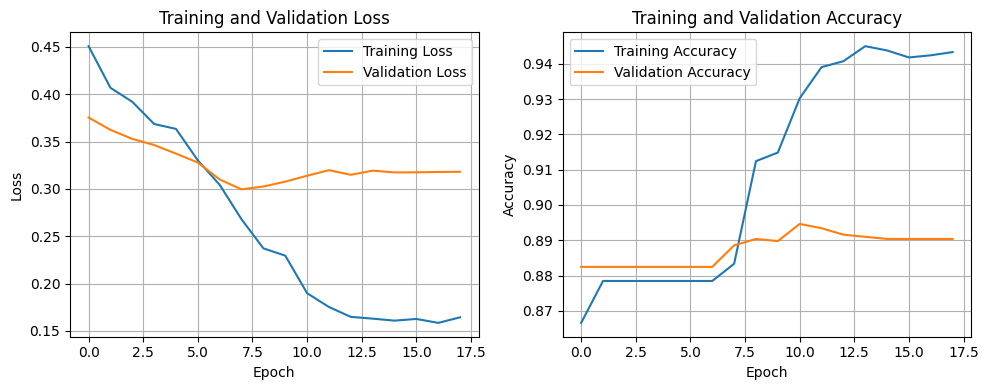

In [50]:
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, classification_report, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt

metricas_modelos = {}

def modelo_con_batch(batch_size, nombre_modelo):
    global metricas_modelos

    vocab_size = 10000
    MAX_SEQUENCE_LENGTH = 100

    X_raw = df['cleaned_review']
    Y_raw = df['sentiment'].apply(lambda x: 1 if x == '1' else (0 if x == '-1' else 0.5)).astype(int)

    X_train_raw, X_test_raw, Y_train_raw, Y_test_raw = train_test_split(
        X_raw, Y_raw, test_size=0.2, random_state=42, stratify=Y_raw
    )

    tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
    tokenizer.fit_on_texts(X_train_raw)
    X_train_sequences = tokenizer.texts_to_sequences(X_train_raw)
    X_test_sequences = tokenizer.texts_to_sequences(X_test_raw)
    X_train_padded = pad_sequences(X_train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
    X_test_padded = pad_sequences(X_test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

    Y_train = np.array(Y_train_raw)
    Y_test = np.array(Y_test_raw)

    def build_model(vocab_size, max_sequence_length):
        model = Sequential([
            Embedding(input_dim=vocab_size, output_dim=128, input_length=max_sequence_length),
            SpatialDropout1D(0.2),
            GlobalAveragePooling1D(),
            Dense(64, activation='relu'),
            Dropout(0.5),
            Dense(32, activation='relu'),
            Dropout(0.5),
            Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model

    model = build_model(vocab_size, MAX_SEQUENCE_LENGTH)
    history = model.fit(
        X_train_padded, Y_train,
        epochs=10, batch_size=batch_size, validation_split=0.2,
        callbacks=[
            EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
            ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, mode="min"),
        ]
    )

    model.save(f"{nombre_modelo}.h5")

    y_pred = model.predict(X_test_padded).flatten()
    accuracy = accuracy_score(Y_test, y_pred.round())
    f1 = f1_score(Y_test, y_pred.round(), average='weighted')
    roc_auc = roc_auc_score(Y_test, y_pred)

    metricas_modelos[nombre_modelo] = {
        'accuracy': accuracy,
        'f1_score': f1,
        'roc_auc': roc_auc
    }

    print(f"Modelo {nombre_modelo}:")
    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")
    print(f"ROC-AUC: {roc_auc}")
    print(classification_report(Y_test, y_pred.round()))
    plot_history(history)

modelo_con_batch(32, "Modelo_Batch_32")
modelo_con_batch(64, "Modelo_Batch_64")
modelo_con_batch(128, "Modelo_Batch_128")


## Análisis en conjunto con las gráficas:

###Modelo_Batch_32:
Como vimos en las gráficas, este modelo muestra la convergencia más rápida en el entrenamiento, pero también signos de sobreajuste (la pérdida de validación empieza a subir).
En cuanto a las métricas, tiene el mejor Accuracy (0.8909) y el mejor F1 Score (0.8835) de los tres modelos. Sin embargo, su ROC-AUC (0.8280) es el más bajo. Esto sugiere que, aunque clasifica correctamente la mayoría de las instancias, su capacidad para distinguir entre las clases es menor. El sobreajuste podría estar afectando negativamente esta métrica.

###Modelo_Batch_64:
Las gráficas muestran una convergencia más estable y una mejor generalización que el modelo de batch 32.
Las métricas confirman esto. Si bien su Accuracy (0.8782) y F1 Score (0.8316) son ligeramente inferiores al modelo de batch 32, su ROC-AUC (0.8439) es el más alto de los tres. Esto indica una mejor capacidad para discriminar entre las clases. El menor sobreajuste se traduce en una mejor capacidad de generalización.

###Modelo_Batch_128:
Las gráficas muestran una convergencia más lenta en el entrenamiento, similar al modelo de batch 64 en cuanto a la generalización.
Sus métricas se sitúan entre los otros dos modelos. Su Accuracy (0.8831) es intermedio, su F1 Score (0.8376) es mejor que el de batch 64 pero peor que el de batch 32, y su ROC-AUC (0.8362) también está en un punto intermedio.
Conclusión final:

###Considerando tanto las gráficas como las métricas, se puede concluir lo siguiente:

***El Modelo_Batch_32***, aunque obtiene el mejor Accuracy y F1 Score, **sufre de sobreajuste**, lo que se refleja en un menor ROC-AUC. Esto significa que, aunque clasifica correctamente un mayor número de instancias, su capacidad para distinguir entre las clases (sensibilidad y especificidad) es menor. No es la mejor opción debido a este problema de generalización.

***El Modelo_Batch_64*** ofrece el **mejor equilibrio entre generalización y rendimiento**. Su ROC-AUC es el más alto, lo que indica una mejor capacidad para discriminar entre clases, y su Accuracy y F1 Score son aceptables, aunque ligeramente inferiores al modelo de batch 32. Este modelo probablemente generalizará mejor a datos nuevos.

***El Modelo_Batch_128*** muestra una convergencia más lenta y no ofrece una mejora significativa en la generalización en comparación con el modelo de batch 64. Por lo tanto, **no se considera la mejor opción**.

------------------------------------------------------------------------------
###Más allá de los resultados obtenidos los modelos entrenados no son optimos para la detección de casos negativos ya que su valor de precisión es muy bajo en estos casos

### Se proceden a cargar los modelos previamente guardados para su utulización

In [84]:
from tensorflow.keras.models import load_model

# Cargar modelos entrenados previamente
modelo_batch_32 = load_model('Modelo_Batch_32.h5')
modelo_batch_64 = load_model('Modelo_Batch_64.h5')
modelo_batch_128 = load_model('Modelo_Batch_128.h5')

# Ahora puedes usar los modelos cargados en las predicciones
modelos_entrenados = {
    'Modelo_Batch_32': modelo_batch_32,
    'Modelo_Batch_64': modelo_batch_64,
    'Modelo_Batch_128': modelo_batch_128
}


### Como consecuencia de los malos resultados de los modelos anteriores en los casos de predicciones negativas, se procede a hacer un  balanceo de clases para intentar obtener mejores resultados.

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.8780 - loss: 0.4532 - val_accuracy: 0.8825 - val_loss: 0.3632 - learning_rate: 0.0010
Epoch 2/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8853 - loss: 0.3654 - val_accuracy: 0.8825 - val_loss: 0.3490 - learning_rate: 0.0010
Epoch 3/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.8795 - loss: 0.3584 - val_accuracy: 0.8825 - val_loss: 0.3387 - learning_rate: 0.0010
Epoch 4/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8766 - loss: 0.3319 - val_accuracy: 0.8825 - val_loss: 0.3744 - learning_rate: 0.0010
Epoch 5/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8779 - loss: 0.2909 - val_accuracy: 0.8886 - val_loss: 0.3064 - learning_rate: 0.0010


65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Modelo Modelo_Batch_32:
Accuracy: 0.8821237213833415
F1 Score: 0.8377853970493561
ROC-AUC: 0.8312572602984541
              precision    recall  f1-score   support

           0       0.62      0.06      0.12       248
           1       0.89      0.99      0.94      1805

    accuracy                           0.88      2053
   macro avg       0.75      0.53      0.53      2053
weighted avg       0.85      0.88      0.84      2053



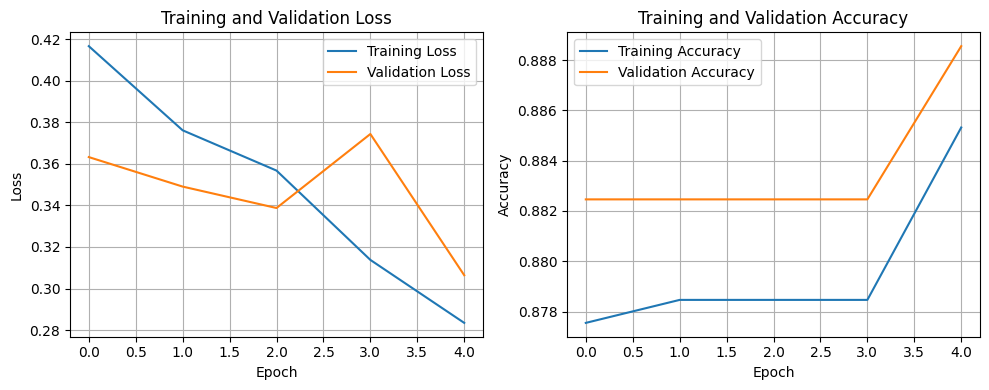

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


103/103 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.8645 - loss: 0.4712 - val_accuracy: 0.8825 - val_loss: 0.3696 - learning_rate: 0.0010
Epoch 2/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8822 - loss: 0.3795 - val_accuracy: 0.8825 - val_loss: 0.3542 - learning_rate: 0.0010
Epoch 3/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8790 - loss: 0.3796 - val_accuracy: 0.8825 - val_loss: 0.3454 - learning_rate: 0.0010
Epoch 4/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8824 - loss: 0.3473 - val_accuracy: 0.8825 - val_loss: 0.3475 - learning_rate: 0.0010
Epoch 5/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8796 - loss: 0.3184 - val_accuracy: 0.8825 - val_loss: 0.3422 - learning_rate: 0.0010


65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Modelo Modelo_Batch_64:
Accuracy: 0.8792011690209449
F1 Score: 0.8226843494467629
ROC-AUC: 0.8359775712626217
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       248
           1       0.88      1.00      0.94      1805

    accuracy                           0.88      2053
   macro avg       0.44      0.50      0.47      2053
weighted avg       0.77      0.88      0.82      2053



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


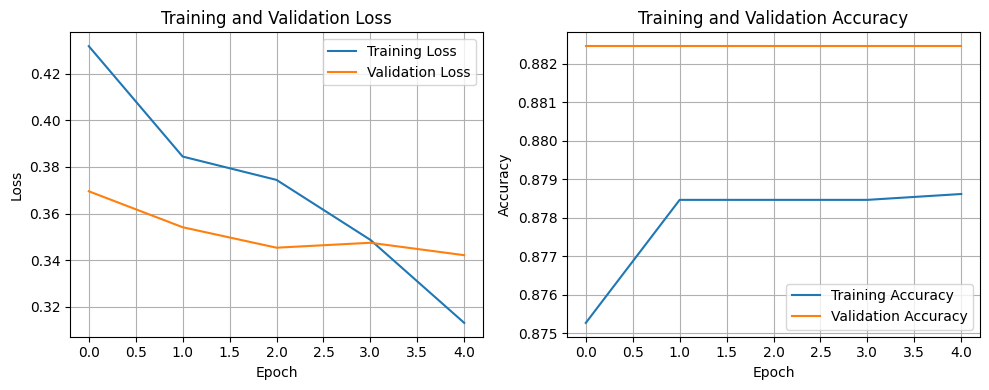

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.8542 - loss: 0.5137 - val_accuracy: 0.8825 - val_loss: 0.3757 - learning_rate: 0.0010
Epoch 2/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8776 - loss: 0.4155 - val_accuracy: 0.8825 - val_loss: 0.3632 - learning_rate: 0.0010
Epoch 3/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8835 - loss: 0.3815 - val_accuracy: 0.8825 - val_loss: 0.3539 - learning_rate: 0.0010
Epoch 4/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8797 - loss: 0.3716 - val_accuracy: 0.8825 - val_loss: 0.3478 - learning_rate: 0.0010
Epoch 5/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8767 - loss: 0.3723 - val_accuracy: 0.8825 - val_loss: 0.3403 - learning_rate: 0.0010


65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Modelo Modelo_Batch_128:
Accuracy: 0.8792011690209449
F1 Score: 0.8226843494467629
ROC-AUC: 0.8162653024752032
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       248
           1       0.88      1.00      0.94      1805

    accuracy                           0.88      2053
   macro avg       0.44      0.50      0.47      2053
weighted avg       0.77      0.88      0.82      2053



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


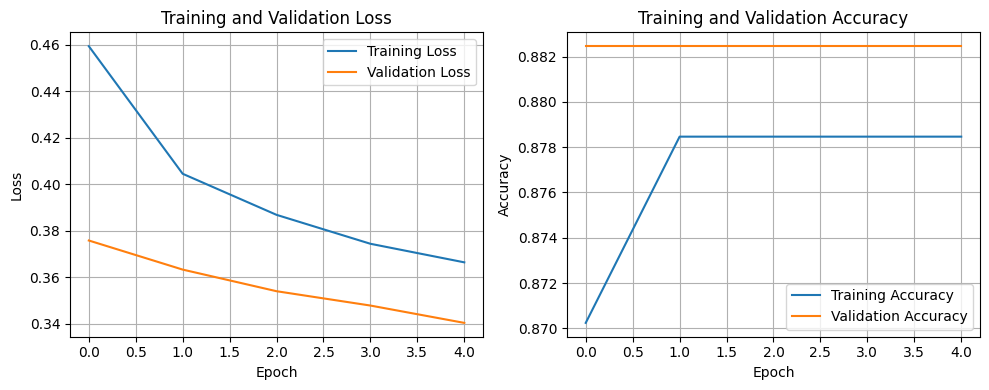

In [86]:
from sklearn.utils import class_weight
import numpy as np
import pandas as pd


def calcular_class_weights(Y_train):
    Y_train = np.ravel(Y_train)

    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(Y_train),
        y=Y_train
    )
    return dict(enumerate(class_weights))


class_weights = calcular_class_weights(Y_train)


def modelo_con_batch_y_class_weight(batch_size, nombre_modelo):
    global metricas_modelos

    vocab_size = 10000
    MAX_SEQUENCE_LENGTH = 100

    X_raw = df['cleaned_review']
    Y_raw = df['sentiment'].apply(lambda x: 1 if x == '1' else (0 if x == '-1' else 0.5)).astype(int)

    X_train_raw, X_test_raw, Y_train_raw, Y_test_raw = train_test_split(
        X_raw, Y_raw, test_size=0.2, random_state=42, stratify=Y_raw
    )

    tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
    tokenizer.fit_on_texts(X_train_raw)
    X_train_sequences = tokenizer.texts_to_sequences(X_train_raw)
    X_test_sequences = tokenizer.texts_to_sequences(X_test_raw)
    X_train_padded = pad_sequences(X_train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
    X_test_padded = pad_sequences(X_test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

    Y_train = np.array(Y_train_raw)
    Y_test = np.array(Y_test_raw)

    def build_model(vocab_size, max_sequence_length):
        model = Sequential([
            Embedding(input_dim=vocab_size, output_dim=128, input_length=max_sequence_length),
            SpatialDropout1D(0.2),
            GlobalAveragePooling1D(),
            Dense(64, activation='relu'),
            Dropout(0.5),
            Dense(32, activation='relu'),
            Dropout(0.5),
            Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model

    model = build_model(vocab_size, MAX_SEQUENCE_LENGTH)
    history = model.fit(
        X_train_padded, Y_train,
        epochs=15, batch_size=batch_size, validation_split=0.2,
        class_weight=class_weights,
        callbacks=[
            EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
            ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, mode="min"),
        ]
    )

    model.save(f"{nombre_modelo}.h5")
    y_pred = model.predict(X_test_padded).flatten()
    accuracy = accuracy_score(Y_test, y_pred.round())
    f1 = f1_score(Y_test, y_pred.round(), average='weighted')
    roc_auc = roc_auc_score(Y_test, y_pred)

    metricas_modelos[nombre_modelo] = {
        'accuracy': accuracy,
        'f1_score': f1,
        'roc_auc': roc_auc
    }

    print(f"Modelo {nombre_modelo}:")
    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")
    print(f"ROC-AUC: {roc_auc}")
    print(classification_report(Y_test, y_pred.round()))
    plot_history(history)


modelo_con_batch_y_class_weight(32, "Modelo_Batch_32")
modelo_con_batch_y_class_weight(64, "Modelo_Batch_64")
modelo_con_batch_y_class_weight(128, "Modelo_Batch_128")


### Al igual que los primeros modelos entrenados éste sigue siendo ineficiente a la hora de identificar calificaciones negativas. Es por esta razón que se utilizará Keras Tuner que es una herramienta de optimización de hiperparámetros para modelos Keras que facilita la búsqueda de los mejores parámetros, incluyendo epochs y batch_size.

In [88]:
!pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.3 MB/s eta 0:00:00


In [97]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, SpatialDropout1D, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
import numpy as np

def build_model(hp):
    vocab_size = 10000
    MAX_SEQUENCE_LENGTH = 100

    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=128))
    model.add(SpatialDropout1D(0.2))
    model.add(GlobalAveragePooling1D())

    model.add(Dense(units=hp.Int('units', min_value=64, max_value=256, step=64), activation='relu'))
    model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


def modelo_con_batch_y_class_weight(batch_size, nombre_modelo, X_train_padded, Y_train, X_test_padded, Y_test, class_weights):
    global metricas_modelos

    model = build_model(hp)

    history = model.fit(
        X_train_padded, Y_train,
        epochs=5, batch_size=batch_size, validation_split=0.2,
        class_weight=class_weights,
        callbacks=[
            EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
            ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, mode="min"),
        ]
    )

    y_pred = model.predict(X_test_padded).flatten()
    accuracy = accuracy_score(Y_test, y_pred.round())
    f1 = f1_score(Y_test, y_pred.round(), average='weighted')
    roc_auc = roc_auc_score(Y_test, y_pred)

    metricas_modelos[nombre_modelo] = {
        'accuracy': accuracy,
        'f1_score': f1,
        'roc_auc': roc_auc
    }

    print(f"Modelo {nombre_modelo}:")
    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")
    print(f"ROC-AUC: {roc_auc}")
    print(classification_report(Y_test, y_pred.round()))

X_train_raw, X_test_raw, Y_train_raw, Y_test_raw = train_test_split(
    df['cleaned_review'], df['sentiment'], test_size=0.2, random_state=42, stratify=df['sentiment']
)

tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_raw)

X_train_sequences = tokenizer.texts_to_sequences(X_train_raw)
X_test_sequences = tokenizer.texts_to_sequences(X_test_raw)

MAX_SEQUENCE_LENGTH = 100
X_train_padded = np.array(X_train_padded).astype(np.int32)
X_test_padded = np.array(X_test_padded).astype(np.int32)

Y_train = np.array(Y_train_raw).astype(np.float32)
Y_test = np.array(Y_test_raw).astype(np.float32)

class_weights = calcular_class_weights(Y_train)


tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    hyperband_iterations=2,
    directory='my_dir',
    project_name='sentiment_analysis_tuning'
)

tuner.search(X_train_padded, Y_train, epochs=10, validation_data=(X_test_padded, Y_test))
best_model = tuner.get_best_models()[0]

best_model.evaluate(X_test_padded, Y_test)


Trial 56 Complete [00h 01m 04s]
val_accuracy: 0.8947880864143372

Best val_accuracy So Far: 0.8996590375900269
Total elapsed time: 00h 26m 31s
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8955 - loss: 0.3345


[0.3122098743915558, 0.8996590375900269]

## **Resultados Clave del proceso de mejora**
### 1. Mejor precisión en el conjunto de validación (val_accuracy):

 * La mejor precisión en el conjunto de validación fue 0.8997 (≈ 90%), lo que indica que el modelo generaliza bien a los datos de validación.
 * El hiperparámetro que produjo este resultado se almacenó como best_model.

### 2. Evaluación del mejor modelo en el conjunto de prueba:

* La evaluación final en los datos de prueba arrojó:
 * Precisión (accuracy): 0.8955 (≈ 89.6%).
 * Pérdida (loss): 0.3345.

Esto significa que el modelo tiene un rendimiento consistente en ambos conjuntos (validación y prueba), lo cual es un indicador de que no está sobreajustado.

### 3. Mejor puntuación lograda durante la búsqueda (Best val_accuracy So Far):

 * La búsqueda encontró la mejor configuración de hiperparámetros en 26 minutos y 31 segundos.

### Reporte de Clasificación y Métricas Adicionales:
A continuación obtenemos los resultados mas detallados de las métricas obtenidas

In [98]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred_probs = best_model.predict(X_test_padded).flatten()
y_pred = (y_pred_probs >= 0.5).astype(int)

print("ROC-AUC Score:", roc_auc_score(Y_test, y_pred_probs))
print(classification_report(Y_test, y_pred))


65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
ROC-AUC Score: 0.8222254490215352
              precision    recall  f1-score   support

         0.0       0.64      0.40      0.49       248
         1.0       0.92      0.97      0.94      1805

    accuracy                           0.90      2053
   macro avg       0.78      0.68      0.72      2053
weighted avg       0.89      0.90      0.89      2053



Guardamos el modelo

In [99]:
best_model.save("sentiment_analysis_model.h5")


Cargamos el nuevo modelo

In [100]:
from tensorflow.keras.models import load_model

loaded_model = load_model("sentiment_analysis_model.h5")


In [112]:

texto_negativo = "I hate this product. It is the worst thing I've ever bought. Terrible experience!"


secuencia_negativa = tokenizer.texts_to_sequences([texto_negativo])
secuencia_negativa_padded = pad_sequences(secuencia_negativa, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')


probabilidad_sentimiento = best_model.predict(secuencia_negativa_padded).flatten()[0]
prediccion_sentimiento = "Positivo" if probabilidad_sentimiento >= 0.5 else "Negativo"

print(f"Texto: {texto_negativo}")
print(f"Probabilidad de sentimiento positivo: {probabilidad_sentimiento:.4f}")
print(f"Predicción: {prediccion_sentimiento}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Texto: I hate this product. It is the worst thing I've ever bought. Terrible experience!
Probabilidad de sentimiento positivo: 0.5731
Predicción: Positivo


### Como podemos observar al inresar un texto claramente negativo la predicción sigue siendo positiva con lo cual en lugar de fijar arbitrariamente un valor (como 0.5), optimizamos el umbral basado en el rendimiento en el conjunto de validación

In [113]:
from sklearn.metrics import roc_curve

y_probs = best_model.predict(X_test_padded).flatten()

fpr, tpr, umbrales = roc_curve(Y_test, y_probs)

optimal_idx = np.argmax(tpr - fpr)
optimal_umbral = umbrales[optimal_idx]

print(f"El umbral óptimo es: {optimal_umbral}")


65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
El umbral óptimo es: 0.7984963059425354


El umbral óptimo encontrado es 0.7985, lo que significa que el modelo necesita una probabilidad igual o superior al 79.85% para clasificar un texto como positivo. Esto indica que el modelo es más conservador con las predicciones positivas, lo que puede ayudar a reducir falsos positivos pero aumentar falsos negativos.

In [110]:
texto_prueba = "I hate this product. It is the worst thing I've ever bought. Terrible experience!"
texto_secuencia = tokenizer.texts_to_sequences([texto_prueba])
texto_padded = pad_sequences(texto_secuencia, maxlen=100, padding='post', truncating='post')

probabilidad_sentimiento = best_model.predict(texto_padded).flatten()[0]

prediccion = "Positivo" if probabilidad_sentimiento >= 0.7985 else "Negativo"

print(f"Texto: {texto_prueba}")
print(f"Probabilidad de sentimiento positivo: {probabilidad_sentimiento:.4f}")
print(f"Predicción: {prediccion}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Texto: I hate this product. It is the worst thing I've ever bought. Terrible experience!
Probabilidad de sentimiento positivo: 0.5731
Predicción: Negativo


Ahora el modelo clasifica correctamente el texto negativo como "Negativo", ya que la probabilidad de sentimiento positivo (0.5731) está por debajo del umbral óptimo (0.7985). Esto confirma que el ajuste del umbral mejora la precisión de las predicciones.

In [111]:
texto_prueba = "I absolutely love this product! It exceeded all my expectations and made my life so much easier. Highly recommended!"
texto_secuencia = tokenizer.texts_to_sequences([texto_prueba])
texto_padded = pad_sequences(texto_secuencia, maxlen=100, padding='post', truncating='post')


probabilidad_sentimiento = best_model.predict(texto_padded).flatten()[0]

prediccion = "Positivo" if probabilidad_sentimiento >= 0.7985 else "Negativo"

print(f"Texto: {texto_prueba}")
print(f"Probabilidad de sentimiento positivo: {probabilidad_sentimiento:.4f}")
print(f"Predicción: {prediccion}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Texto: I absolutely love this product! It exceeded all my expectations and made my life so much easier. Highly recommended!
Probabilidad de sentimiento positivo: 0.8869
Predicción: Positivo


El modelo está funcionando correctamente y clasifica el texto positivo con una alta probabilidad de sentimiento positivo (0.8869), superando el umbral óptimo que se determinó en (0.7985)

In [114]:
texto_prueba = "The service was awful. I waited for hours and no one helped me. Totally disappointed!"
texto_secuencia = tokenizer.texts_to_sequences([texto_prueba])
texto_padded = pad_sequences(texto_secuencia, maxlen=100, padding='post', truncating='post')

probabilidad_sentimiento = best_model.predict(texto_padded).flatten()[0]

prediccion = "Positivo" if probabilidad_sentimiento >= 0.7985 else "Negativo"

print(f"Texto: {texto_prueba}")
print(f"Probabilidad de sentimiento positivo: {probabilidad_sentimiento:.4f}")
print(f"Predicción: {prediccion}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Texto: The service was awful. I waited for hours and no one helped me. Totally disappointed!
Probabilidad de sentimiento positivo: 0.5065
Predicción: Negativo
